In [1]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.models as models
import torch.optim as optim
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchattacks
import matplotlib.pyplot as plt

In [26]:
model_name = "Mobilenetv3Small"
version = "v1"
training_name = "NORMAL"
num_classes = 7
batch_size = 32
learning_rate = 0.0001
lr_factor = 0.1
lr_threshold = 5
epochs = 50
height = 224

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
# Graph writer initialize
writer = SummaryWriter("runs/trashbox/" + f'{training_name}--{model_name}.{version}')

In [28]:
preprocessing = transforms.Compose([
    transforms.RandomResizedCrop((height, height)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
])

In [29]:
trash_train_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/train', transform=preprocessing)
trash_train_loader = torch.utils.data.DataLoader(dataset=trash_train_dataset, shuffle=True, batch_size=batch_size)
trash_val_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/val', transform=preprocessing)
trash_val_loader = torch.utils.data.DataLoader(dataset=trash_val_dataset, shuffle=True, batch_size=batch_size)

In [30]:
weights = models.MobileNet_V3_Small_Weights.DEFAULT
model = models.mobilenet_v3_small(weights=weights)
model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=num_classes, bias=True)
)
model = model.to(device)
model = torch.nn.DataParallel(model)

In [31]:
criterion = nn.CrossEntropyLoss()

c:\Users\MY PC\anaconda3\envs\thesisaimodel\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor(1.)
tensor(0.)
torch.Size([32, 3, 224, 224])


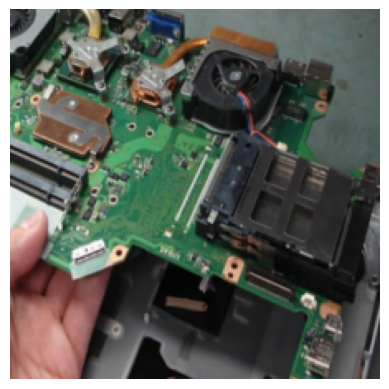

In [32]:
examples = iter(trash_val_loader)
samples, labels = next(examples)

if samples.ndim > 3:
    new_samples = samples.squeeze()

    # If the tensor has 4 dimensions (batch dimension), select the first image in the batch
if samples.ndim == 4:
    new_samples = samples[0]
image_array = new_samples.permute(1, 2, 0).numpy()

# Show min and max values for normalization
print(torch.max(samples))
print(torch.min(samples))
print(samples.shape)

plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

In [33]:
def train(epoch, optimizer): 
    print(f'Train epoch no. [{epoch}]')
    train_loss = 0
    correct = 0
    total = 0
    model.train()
    iterator = tqdm(trash_train_loader, ncols=0, leave=False)
    for i, (inputs, targets)in enumerate(iterator):
        inputs, targets = inputs.to(device),targets.to(device)

        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    validation_loss = train_loss / len(trash_train_loader)
    print('\nTotal train accuarcy:', 100. * correct / total)
    print('Validation loss:', validation_loss)
    print('Total train loss:', train_loss)
    
    writer.add_scalar('Train loss: ' + model_name, validation_loss, epoch)
    writer.add_scalar('Train accuracy: ' + model_name, 100. * correct / total, epoch)
    return train_loss

In [34]:
best_loss = float('inf')

def test(epoch, optimizer):
    print('\n[ Test epoch: %d ]' % epoch)
    global best_loss
    model.eval()
    benigh_loss = 0
    adv_loss = 0
    adv_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        iterator = tqdm(trash_val_loader, ncols=0, leave=False)
        for i, (inputs, targets) in enumerate(iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)
            # For clean images
            output = model(inputs)
            clean_loss = criterion(output, targets)
            benigh_loss += clean_loss.item()

            _, predicted = output.max(1)
            correct += predicted.eq(targets).sum().item()
        
    benign_validation_loss = benigh_loss / len(trash_val_loader)
    benign_accuracy = correct / total

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test loss:', benign_validation_loss)


    # Graph
    writer.add_scalar("Test accuracy: " + model_name, 100. * benign_accuracy, epoch)
    writer.add_scalar("Test loss: " + model_name, benign_validation_loss, epoch)

    # Save checkpoint
    state = {
        'epoch' : epoch,
        'net': model.state_dict(),
        'optim' : optimizer.state_dict(),
        'loss' : adv_loss
    }

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + f'{training_name}--{model_name}.{version}.pth')
    print('Model Saved!')

    if benign_validation_loss < best_loss:
        print(f'New best loss saved: {benign_validation_loss}')
        best_loss = benign_validation_loss
        torch.save(state, './trained_model/' + f'best_{training_name}--{model_name}.{version}_epoch{epoch}.pth')
    return benign_accuracy, benign_validation_loss

In [35]:
def main():
    global learning_rate
    learning_rate = learning_rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=lr_threshold, factor=0.1)
    model_path = f'./checkpoint/{training_name}--{model_name}.{version}.pth'
    if os.path.exists(model_path):
        # Load the saved model and optimizer state
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'])
        optimizer.load_state_dict(checkpoint['optim'])
        start_epoch = checkpoint['epoch']
        print(f"=> Loaded checkpoint '{model_path}' (epoch {start_epoch})")
    else:
        start_epoch = 0
        print(f"=> No checkpoint found at '{model_path}'. Starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        train_loss = train(epoch, optimizer)
        _, benign_validation_loss = test(epoch, optimizer)
        scheduler.step(metrics=benign_validation_loss, epoch=epoch)
        scheduler.print_lr(True, model.parameters(), learning_rate, epoch)


In [36]:
if __name__ == '__main__':
    main()

=> No checkpoint found at './checkpoint/NORMAL--Mobilenetv3Small.v1.pth'. Starting training from scratch.
Train epoch no. [0]



Total train accuarcy: 64.9345192240353
Validation loss: 1.0258000738402073
Total train loss: 458.5326330065727

[ Test epoch: 0 ]


c:\Users\MY PC\anaconda3\envs\thesisaimodel\Lib\site-packages\torch\optim\lr_scheduler.py:1056: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Test accuarcy: 75.85626052779338
Test loss: 0.7055960052779743
Model Saved!
New best loss saved: 0.7055960052779743
Epoch 00000: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [1]



Total train accuarcy: 77.1832761397857
Validation loss: 0.665335234112921
Total train loss: 297.40484964847565

[ Test epoch: 1 ]



Test accuarcy: 81.35878719820326
Test loss: 0.5961934993309634
Model Saved!
New best loss saved: 0.5961934993309634
Epoch 00001: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06DC0> to 1.0000e-04.
Train epoch no. [2]



Total train accuarcy: 80.55185937390574
Validation loss: 0.5731689213906359
Total train loss: 256.2065078616142

[ Test epoch: 2 ]



Test accuarcy: 81.0780460415497
Test loss: 0.5664704106748104
Model Saved!
New best loss saved: 0.5664704106748104
Epoch 00002: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [3]



Total train accuarcy: 81.910497934029
Validation loss: 0.535045742705231
Total train loss: 239.16544698923826

[ Test epoch: 3 ]



Test accuarcy: 81.58338012352611
Test loss: 0.5239145196974277
Model Saved!
New best loss saved: 0.5239145196974277
Epoch 00003: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [4]



Total train accuarcy: 83.26213320260523
Validation loss: 0.4861417774786085
Total train loss: 217.305374532938

[ Test epoch: 4 ]



Test accuarcy: 82.76249298147108
Test loss: 0.5053495833916324
Model Saved!
New best loss saved: 0.5053495833916324
Epoch 00004: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [5]



Total train accuarcy: 84.24959731073605
Validation loss: 0.45886271348602287
Total train loss: 205.11163292825222

[ Test epoch: 5 ]



Test accuarcy: 83.77316114542391
Test loss: 0.5028299524315766
Model Saved!
New best loss saved: 0.5028299524315766
Epoch 00005: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [6]



Total train accuarcy: 85.25106800196092
Validation loss: 0.43153090351646645
Total train loss: 192.8943138718605

[ Test epoch: 6 ]



Test accuarcy: 83.43627175743964
Test loss: 0.4979536562625851
Model Saved!
New best loss saved: 0.4979536562625851
Epoch 00006: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [7]



Total train accuarcy: 86.07745640451012
Validation loss: 0.4042496852060026
Total train loss: 180.69960928708315

[ Test epoch: 7 ]



Test accuarcy: 84.05390230207749
Test loss: 0.47086177819541525
Model Saved!
New best loss saved: 0.47086177819541525
Epoch 00007: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [8]



Total train accuarcy: 86.66573289446039
Validation loss: 0.3885707329683656
Total train loss: 173.69111763685942

[ Test epoch: 8 ]



Test accuarcy: 84.67153284671532
Test loss: 0.47388177418283056
Model Saved!
Epoch 00008: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06DC0> to 1.0000e-04.
Train epoch no. [9]



Total train accuarcy: 87.34505217452202
Validation loss: 0.37497927970200845
Total train loss: 167.61573802679777

[ Test epoch: 9 ]



Test accuarcy: 83.99775407074677
Test loss: 0.48978023417294025
Model Saved!
Epoch 00009: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06DC0> to 1.0000e-04.
Train epoch no. [10]



Total train accuarcy: 87.8282792912669
Validation loss: 0.3531075593842489
Total train loss: 157.83907904475927

[ Test epoch: 10 ]



Test accuarcy: 85.06457046603032
Test loss: 0.4491091852209398
Model Saved!
New best loss saved: 0.4491091852209398
Epoch 00010: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [11]



Total train accuarcy: 87.87029904054906
Validation loss: 0.35109713485243604
Total train loss: 156.9404192790389

[ Test epoch: 11 ]



Test accuarcy: 84.89612577203818
Test loss: 0.47342946593250546
Model Saved!
Epoch 00011: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [12]



Total train accuarcy: 88.7317039008334
Validation loss: 0.33056210949016895
Total train loss: 147.76126294210553

[ Test epoch: 12 ]



Test accuarcy: 84.44693992139247
Test loss: 0.5047438615666968
Model Saved!
Epoch 00012: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [13]



Total train accuarcy: 89.55108901183556
Validation loss: 0.3122447314411735
Total train loss: 139.57339495420456

[ Test epoch: 13 ]



Test accuarcy: 85.17686692869175
Test loss: 0.46102493735296385
Model Saved!
Epoch 00013: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [14]



Total train accuarcy: 89.43903634708313
Validation loss: 0.3116306385037883
Total train loss: 139.29889541119337

[ Test epoch: 14 ]



Test accuarcy: 85.00842223469961
Test loss: 0.48407846176996827
Model Saved!
Epoch 00014: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [15]



Total train accuarcy: 89.74718117515232
Validation loss: 0.29938798586960874
Total train loss: 133.8264296837151

[ Test epoch: 15 ]



Test accuarcy: 84.44693992139247
Test loss: 0.4815617342080389
Model Saved!
Epoch 00015: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [16]



Total train accuarcy: 90.02030954548638
Validation loss: 0.3003628287939417
Total train loss: 134.26218447089195

[ Test epoch: 16 ]



Test accuarcy: 84.78382930937676
Test loss: 0.4760739289756332
Model Saved!
Epoch 00016: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06DC0> to 1.0000e-04.
Train epoch no. [17]



Total train accuarcy: 91.40696127179774
Validation loss: 0.26135826767557685
Total train loss: 116.82714565098286

[ Test epoch: 17 ]



Test accuarcy: 86.692869174621
Test loss: 0.43789368495345116
Model Saved!
New best loss saved: 0.43789368495345116
Epoch 00017: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [18]



Total train accuarcy: 91.70810280831991
Validation loss: 0.24972481975619426
Total train loss: 111.62699443101883

[ Test epoch: 18 ]



Test accuarcy: 86.24368332397529
Test loss: 0.4410669259460909
Model Saved!
Epoch 00018: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [19]



Total train accuarcy: 91.56803697737936
Validation loss: 0.254145923568565
Total train loss: 113.60322783514857

[ Test epoch: 19 ]



Test accuarcy: 85.62605277933746
Test loss: 0.4638840574771166
Model Saved!
Epoch 00019: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [20]



Total train accuarcy: 91.78513901533721
Validation loss: 0.2476852189007755
Total train loss: 110.71529284864664

[ Test epoch: 20 ]



Test accuarcy: 85.34531162268388
Test loss: 0.4554693265152829
Model Saved!
Epoch 00020: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [21]



Total train accuarcy: 91.92520484627775
Validation loss: 0.24169770157343856
Total train loss: 108.03887260332704

[ Test epoch: 21 ]



Test accuarcy: 86.13138686131387
Test loss: 0.4419318685042007
Model Saved!
Epoch 00021: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [22]



Total train accuarcy: 92.18432663351776
Validation loss: 0.23313009002198043
Total train loss: 104.20915023982525

[ Test epoch: 22 ]



Test accuarcy: 86.29983155530601
Test loss: 0.4429628210408347
Model Saved!
Epoch 00022: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06960> to 1.0000e-04.
Train epoch no. [23]



Total train accuarcy: 91.90419497163667
Validation loss: 0.23758816456951418
Total train loss: 106.20190956257284

[ Test epoch: 23 ]



Test accuarcy: 86.52442448062887
Test loss: 0.421823259975229
Model Saved!
New best loss saved: 0.421823259975229
Epoch 00023: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [24]



Total train accuarcy: 92.04426080257721
Validation loss: 0.24012055537211283
Total train loss: 107.33388825133443

[ Test epoch: 24 ]



Test accuarcy: 86.29983155530601
Test loss: 0.44004652176850606
Model Saved!
Epoch 00024: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [25]



Total train accuarcy: 91.87618180544857
Validation loss: 0.2409035836323529
Total train loss: 107.68390188366175

[ Test epoch: 25 ]



Test accuarcy: 86.74901740595172
Test loss: 0.4559932879305312
Model Saved!
Epoch 00025: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06960> to 1.0000e-04.
Train epoch no. [26]



Total train accuarcy: 91.89719168008965
Validation loss: 0.23404643620453958
Total train loss: 104.6187569834292

[ Test epoch: 26 ]



Test accuarcy: 86.07523862998316
Test loss: 0.43885557007576736
Model Saved!
Epoch 00026: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [27]



Total train accuarcy: 91.98123117865397
Validation loss: 0.2372363484579178
Total train loss: 106.04464776068926

[ Test epoch: 27 ]



Test accuarcy: 86.18753509264458
Test loss: 0.43721253903848784
Model Saved!
Epoch 00027: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [28]



Total train accuarcy: 92.48546817003992
Validation loss: 0.2241959107968898
Total train loss: 100.21557212620974

[ Test epoch: 28 ]



Test accuarcy: 86.29983155530601
Test loss: 0.4407687100714871
Model Saved!
Epoch 00028: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06DC0> to 1.0000e-04.
Train epoch no. [29]



Total train accuarcy: 92.02325092793613
Validation loss: 0.2360732647438244
Total train loss: 105.5247493404895

[ Test epoch: 29 ]



Test accuarcy: 86.63672094329029
Test loss: 0.45220742893538307
Model Saved!
Epoch 00029: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06960> to 1.0000e-04.
Train epoch no. [30]



Total train accuarcy: 92.33839904755234
Validation loss: 0.2340050761127465
Total train loss: 104.6002690223977

[ Test epoch: 30 ]



Test accuarcy: 86.74901740595172
Test loss: 0.4435791532908167
Model Saved!
Epoch 00030: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06960> to 1.0000e-04.
Train epoch no. [31]



Total train accuarcy: 92.2753694236291
Validation loss: 0.22541477779964073
Total train loss: 100.7604056764394

[ Test epoch: 31 ]



Test accuarcy: 85.73834924199888
Test loss: 0.4520451403888209
Model Saved!
Epoch 00031: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06960> to 1.0000e-04.
Train epoch no. [32]



Total train accuarcy: 92.31738917291126
Validation loss: 0.22782954404868136
Total train loss: 101.83980618976057

[ Test epoch: 32 ]



Test accuarcy: 85.96294216732173
Test loss: 0.44893959164619446
Model Saved!
Epoch 00032: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06960> to 1.0000e-04.
Train epoch no. [33]



Total train accuarcy: 92.34540233909938
Validation loss: 0.22732795007376863
Total train loss: 101.61559368297458

[ Test epoch: 33 ]



Test accuarcy: 85.73834924199888
Test loss: 0.4610202621136393
Model Saved!
Epoch 00033: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [34]



Total train accuarcy: 92.52748791932208
Validation loss: 0.22524647758044386
Total train loss: 100.6851754784584

[ Test epoch: 34 ]



Test accuarcy: 86.18753509264458
Test loss: 0.431037748498576
Model Saved!
Epoch 00034: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06420> to 1.0000e-04.
Train epoch no. [35]



Total train accuarcy: 92.16331675887668
Validation loss: 0.23450678737388228
Total train loss: 104.82453395612538

[ Test epoch: 35 ]



Test accuarcy: 86.97361033127457
Test loss: 0.4485908889078668
Model Saved!
Epoch 00035: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [36]



Total train accuarcy: 92.59051754324533
Validation loss: 0.2250960090883093
Total train loss: 100.61791606247425

[ Test epoch: 36 ]



Test accuarcy: 86.74901740595172
Test loss: 0.4502290513898645
Model Saved!
Epoch 00036: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [37]



Total train accuarcy: 92.38041879683452
Validation loss: 0.22630242466659886
Total train loss: 101.1571838259697

[ Test epoch: 37 ]



Test accuarcy: 86.63672094329029
Test loss: 0.4442383324993508
Model Saved!
Epoch 00037: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06960> to 1.0000e-04.
Train epoch no. [38]



Total train accuarcy: 92.45045171230478
Validation loss: 0.22607748805476516
Total train loss: 101.05663716048002

[ Test epoch: 38 ]



Test accuarcy: 86.63672094329029
Test loss: 0.4298464782269938
Model Saved!
Epoch 00038: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A073E0> to 1.0000e-04.
Train epoch no. [39]



Total train accuarcy: 92.51348133622803
Validation loss: 0.22827013215712652
Total train loss: 102.03674907423556

[ Test epoch: 39 ]



Test accuarcy: 86.86131386861314
Test loss: 0.4462092610608254
Model Saved!
Epoch 00039: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [40]



Total train accuarcy: 92.68856362490371
Validation loss: 0.22003395532484957
Total train loss: 98.35517803020775

[ Test epoch: 40 ]



Test accuarcy: 86.41212801796743
Test loss: 0.4198064033740333
Model Saved!
New best loss saved: 0.4198064033740333
Epoch 00040: adjusting learning rate of group <generator object Module.parameters at 0x0000025B88A06EA0> to 1.0000e-04.
Train epoch no. [41]



Total train accuarcy: 92.54149450241614
Validation loss: 0.2200338145388786
Total train loss: 98.35511509887874

[ Test epoch: 41 ]



Test accuarcy: 85.62605277933746
Test loss: 0.4625873214432171
Model Saved!
Epoch 00041: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD000> to 1.0000e-04.
Train epoch no. [42]



Total train accuarcy: 92.75859654037397
Validation loss: 0.21665659127236078
Total train loss: 96.84549629874527

[ Test epoch: 42 ]



Test accuarcy: 86.52442448062887
Test loss: 0.45721842987196787
Model Saved!
Epoch 00042: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD000> to 1.0000e-04.
Train epoch no. [43]



Total train accuarcy: 92.67455704180965
Validation loss: 0.22784408143569426
Total train loss: 101.84630440175533

[ Test epoch: 43 ]



Test accuarcy: 86.24368332397529
Test loss: 0.4607275598682463
Model Saved!
Epoch 00043: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD000> to 1.0000e-04.
Train epoch no. [44]



Total train accuarcy: 92.57651096015127
Validation loss: 0.22964545295175823
Total train loss: 102.65151746943593

[ Test epoch: 44 ]



Test accuarcy: 86.97361033127457
Test loss: 0.44401662464120556
Model Saved!
Epoch 00044: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD000> to 1.0000e-04.
Train epoch no. [45]



Total train accuarcy: 92.40843196302262
Validation loss: 0.2241436749971753
Total train loss: 100.19222272373736

[ Test epoch: 45 ]



Test accuarcy: 84.33464345873105
Test loss: 0.463108537003531
Model Saved!
Epoch 00045: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD000> to 1.0000e-04.
Train epoch no. [46]



Total train accuarcy: 92.54149450241614
Validation loss: 0.21721048312265867
Total train loss: 97.09308595582843

[ Test epoch: 46 ]



Test accuarcy: 86.07523862998316
Test loss: 0.46415651869028807
Model Saved!
Epoch 00046: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD700> to 1.0000e-04.
Train epoch no. [47]



Total train accuarcy: 92.43644512921072
Validation loss: 0.22811312777234005
Total train loss: 101.966568114236

[ Test epoch: 47 ]



Test accuarcy: 85.62605277933746
Test loss: 0.4704586159703987
Model Saved!
Epoch 00047: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD700> to 1.0000e-04.
Train epoch no. [48]



Total train accuarcy: 92.31038588136424
Validation loss: 0.22427339646423555
Total train loss: 100.2502082195133

[ Test epoch: 48 ]



Test accuarcy: 85.23301516002246
Test loss: 0.46230424381792545
Model Saved!
Epoch 00048: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD700> to 1.0000e-04.
Train epoch no. [49]



Total train accuarcy: 92.70257020799775
Validation loss: 0.21808875819680676
Total train loss: 97.48567491397262

[ Test epoch: 49 ]



Test accuarcy: 86.58057271195958
Test loss: 0.45514946590576855
Model Saved!
Epoch 00049: adjusting learning rate of group <generator object Module.parameters at 0x0000025ADE1AD000> to 1.0000e-04.
